In [1]:
import sys
sys.executable

'C:\\Users\\user\\Anaconda3\\ANACONDA\\python.exe'

In [2]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

import statistics 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

import statsmodels.api as sm

### Some cosmetics add-ons
plt.style.use('fivethirtyeight')
%matplotlib inline

# Loading dataset

In [3]:
s2014 = pd.read_csv('annual_data/nba_season_2014_data.csv')
s2015 = pd.read_csv('annual_data/nba_season_2015_data.csv')
s2016 = pd.read_csv('annual_data/nba_season_2016_data.csv')
s2017 = pd.read_csv('annual_data/nba_season_2017_data.csv')
s2018 = pd.read_csv('annual_data/nba_season_2018_data.csv')
s2019 = pd.read_csv('annual_data/nba_season_2019_data.csv')

In [4]:
s2014.info(verbose=True , null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 111 columns):
SEASON_ID_x            1230 non-null int64
TEAM_ID_x              1230 non-null int64
TEAM_ABBREVIATION_x    1230 non-null object
TEAM_NAME_x            1230 non-null object
GAME_ID                1230 non-null int64
GAME_DATE_x            1230 non-null object
MATCHUP_x              1230 non-null object
WL_x                   1230 non-null int64
MIN_x                  1230 non-null int64
PTS_x                  1230 non-null int64
FGM_x                  1230 non-null int64
FGA_x                  1230 non-null int64
FG_PCT_x               1230 non-null float64
FG3M_x                 1230 non-null int64
FG3A_x                 1230 non-null float64
FG3_PCT_x              1230 non-null float64
FTM_x                  1230 non-null int64
FTA_x                  1230 non-null int64
FT_PCT_x               1230 non-null float64
OREB_x                 1230 non-null float64
DREB_x            

## Removing rows where either teams are playing their first games (the disparity stats will be off for these games)

In [5]:
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    df.drop(df[(df.GAME_PLAYED_x == 1) | (df.GAME_PLAYED_y == 1)].index, inplace = True)

# Creating our target and independent variables

In [6]:
features_list = ['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']
target = 'WL_x'

# Plotting distribution graphs for all the variables

In [7]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

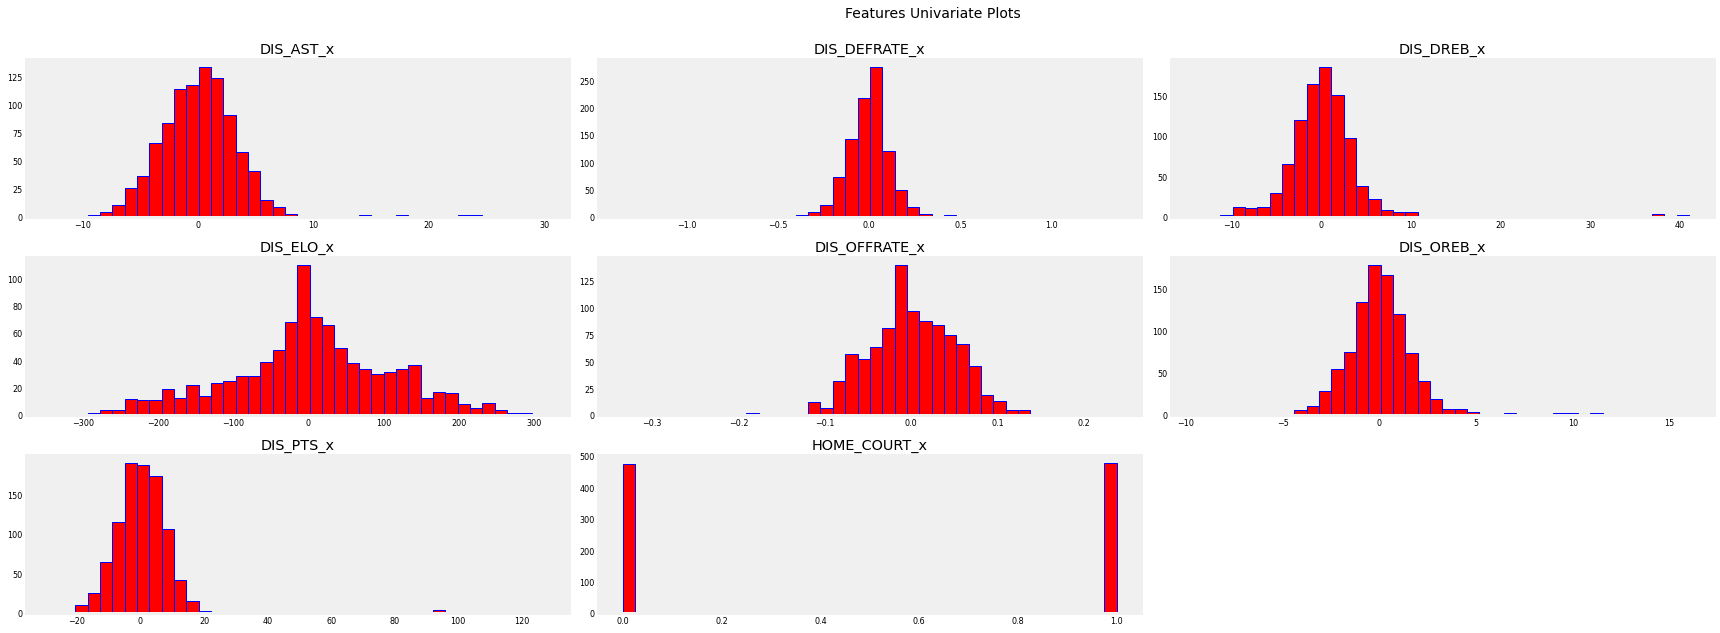

In [8]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

All variables are relatively normally distributed. 

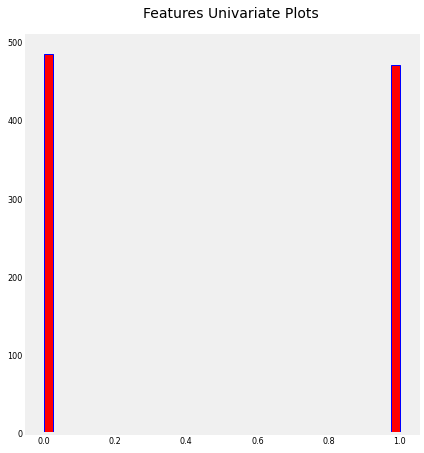

In [9]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

Balanced target variable!

# Training model for each year 

In [10]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False),
    'Linear Regression': LinearRegression()
}

performance_data = {}

In [11]:
season = 2014
models_acc_per_season = {} # to store all the model acc scores for every season
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # Extract first and second half of season data
    first_half = df[(df['GAME_PLAYED_x'] <= 41) | (df['GAME_PLAYED_y'] <= 41 )]
    second_half = df[(df['GAME_PLAYED_x'] > 41) & (df['GAME_PLAYED_y'] > 41 )]

    # Creating our independent and dependent variables df
    x = first_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
    y = first_half['PLUS_MINUS_x']

    # Perform train test split
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
    # X_train.shape, X_test.shape, y_train.shape, y_test.shape

    model = sm.OLS(y,x)
    results = model.fit()

    features_list = []
    for i in range(len(x.keys())):
        if results.pvalues[i] <= 0.05:
            features_list.append(model.exog_names[i])

    X_train = first_half[features_list]
    X_test = second_half[features_list]
    y_train = first_half['WL_x']
    y_test = second_half['WL_x']

    model_acc_score = [] # store all the model acc scores for 1 season
    performance_data[season] = {
        'accuracy':[],
        'precision':[],
        'recall':[],
        'f1':[]
    } # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]

        if model_name == 'Linear Regression':
            y_train = first_half['PLUS_MINUS_x']

        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        if model_name == 'Linear Regression':
            for i, v in enumerate(predictions):
                if v > 0:
                    predictions[i] = 1
                else:
                    predictions[i] = 0

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        model_acc_score.append((model_name, acc))

        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data[season]['accuracy'].append(acc)
        performance_data[season]['precision'].append(precision)
        performance_data[season]['recall'].append(recall)
        performance_data[season]['f1'].append(f1)

        print('Accuracy Score for {} is {:.5f} in season {}'.format(model_name,acc,season))
    
    models_acc_per_season[season] = model_acc_score # add current season models' acc into the dict
    
    print('-'*60)
    print()
    season += 1
    

Accuracy Score for Logistic Regression is 0.67822 in season 2014
Accuracy Score for Naive Bayes is 0.68647 in season 2014
Accuracy Score for Decision Trees is 0.59406 in season 2014
Accuracy Score for SVM linear is 0.68152 in season 2014
Accuracy Score for SVM rbf is 0.67162 in season 2014
Accuracy Score for Random Forest is 0.63531 in season 2014
[01:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost is 0.60891 in season 2014
Accuracy Score for Linear Regression is 0.68647 in season 2014
------------------------------------------------------------

Accuracy Score for Logistic Regression is 0.71452 in season 2015
Accuracy Score for Naive Bayes is 0.69802 in season 2015
Accuracy Score for Decision Trees is 0.6

In [13]:
for k, v in models_acc_per_season.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season[k] = v
    print(f'Best model in {k} is {v[0]}')

Best model in 2014 is ('Naive Bayes', 0.6864686468646864)
Best model in 2015 is ('Logistic Regression', 0.7145214521452146)
Best model in 2016 is ('Linear Regression', 0.6214876033057851)
Best model in 2017 is ('SVM linear', 0.6870860927152318)
Best model in 2018 is ('Naive Bayes', 0.6732673267326733)
Best model in 2019 is ('SVM rbf', 0.653179190751445)


# Performance Analysis

In [14]:
season = 2014
for k, v in performance_data.items():
    print(season)
    print('-'*60)
    performance_df = pd.DataFrame(v,index=list(models_dict.keys()))
    print(performance_df)
    print()
    season+=1

2014
------------------------------------------------------------
                     accuracy  precision    recall        f1
Logistic Regression  0.678218   0.678019  0.706452  0.691943
Naive Bayes          0.686469   0.677515  0.738710  0.706790
Decision Trees       0.594059   0.604575  0.596774  0.600649
SVM linear           0.681518   0.676737  0.722581  0.698908
SVM rbf              0.671617   0.677316  0.683871  0.680578
Random Forest        0.635314   0.644013  0.641935  0.642973
XGBoost              0.608911   0.617363  0.619355  0.618357
Linear Regression    0.686469   0.693548  0.693548  0.693548

2015
------------------------------------------------------------
                     accuracy  precision    recall        f1
Logistic Regression  0.714521   0.717460  0.729032  0.723200
Naive Bayes          0.698020   0.777293  0.574194  0.660482
Decision Trees       0.618812   0.625397  0.635484  0.630400
SVM linear           0.701320   0.708738  0.706452  0.707593
SVM rbf      

In [15]:
models_acc_per_season

{2014: [('Naive Bayes', 0.6864686468646864),
  ('Linear Regression', 0.6864686468646864),
  ('SVM linear', 0.6815181518151815),
  ('Logistic Regression', 0.6782178217821783),
  ('SVM rbf', 0.6716171617161716),
  ('Random Forest', 0.6353135313531353),
  ('XGBoost', 0.6089108910891089),
  ('Decision Trees', 0.594059405940594)],
 2015: [('Logistic Regression', 0.7145214521452146),
  ('Linear Regression', 0.7145214521452146),
  ('SVM linear', 0.7013201320132013),
  ('Naive Bayes', 0.698019801980198),
  ('SVM rbf', 0.6815181518151815),
  ('Random Forest', 0.6551155115511551),
  ('XGBoost', 0.6501650165016502),
  ('Decision Trees', 0.6188118811881188)],
 2016: [('Linear Regression', 0.6214876033057851),
  ('SVM linear', 0.6165289256198347),
  ('Naive Bayes', 0.6132231404958678),
  ('Logistic Regression', 0.6099173553719008),
  ('SVM rbf', 0.596694214876033),
  ('XGBoost', 0.5785123966942148),
  ('Random Forest', 0.5669421487603306),
  ('Decision Trees', 0.5388429752066116)],
 2017: [('SVM li

# Predict using every model

In [16]:
season_df = s2014 # change this to the season df you want to print out the confusion matrix for that season

for model_name in models_dict:
    x = season_df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
    y = season_df['WL_x']

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 

    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

ValueError: X has 8 features per sample; expecting 4

# Changing our X variables to see if we can yield better accuracy in our models

In [ ]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data_2 = {}
performance_data_3 = {}

In [ ]:
season = 2014
models_acc_per_season_2 = {} # to store all the model acc scores for every season
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # Creating our independent and dependent variables df
    x = df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x']] # 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x'
    y = df['WL_x']

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
    # X_train.shape, X_test.shape, y_train.shape, y_test.shape

    model_acc_score = [] # store all the model acc scores for 1 season
    performance_data_2[season] = {
        'accuracy':[],
        'precision':[],
        'recall':[],
        'f1':[]
    } # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        model_acc_score.append((model_name, acc))

        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data_2[season]['accuracy'].append(acc)
        performance_data_2[season]['precision'].append(precision)
        performance_data_2[season]['recall'].append(recall)
        performance_data_2[season]['f1'].append(f1)

        print('Accuracy Score for {} is {:.5f} in season {}'.format(model_name,acc,season))
    
    models_acc_per_season_2[season] = model_acc_score # add current season models' acc into the dict
    
    print('-'*60)
    print()
    season += 1

In [ ]:
for k, v in models_acc_per_season_2.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season_2[k] = v
    print(f'Best model in {k} is {v[0]}')

print()
for k, v in models_acc_per_season.items():
    v.sort(key=lambda x: x[1], reverse = True)
    models_acc_per_season[k] = v
    print(f'Best model in {k} is {v[0]}')

# Splitting data into first half season and second half season, instead of 70% training, 30% testing

In [ ]:
season_yr_df = s2014 # change this to whichever year you wanna analyze

first_half = season_yr_df[(season_yr_df['GAME_PLAYED_x'] <= 41) | (season_yr_df['GAME_PLAYED_y'] <= 41 )]
second_half = season_yr_df[(season_yr_df['GAME_PLAYED_x'] > 41) & (season_yr_df['GAME_PLAYED_y'] > 41 )]

X_train = first_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
X_test = second_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
y_train = first_half['WL_x']
y_test = second_half['WL_x']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False)
}

performance_data_1 = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
}

In [ ]:
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data_1['accuracy'].append(acc)
    performance_data_1['precision'].append(precision)
    performance_data_1['recall'].append(recall)
    performance_data_1['f1'].append(f1)

    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))

In [ ]:
performance_df = pd.DataFrame(performance_data_1,index=list(models_dict.keys()))
performance_df

In [ ]:
for model_name in models_dict:
    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

ENSEMBLING OF MODELS

In [49]:
#  Max Voting 
season_yr_df = s2018 
x = season_yr_df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
y = season_yr_df['WL_x']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
# Max Voting 
model1 = LogisticRegression()
model2 = GaussianNB()
model3 = DecisionTreeClassifier()
model4 = svm.SVC(kernel='linear')
model5 = svm.SVC(kernel='rbf')
model6 = RandomForestClassifier(n_estimators = 100)
model7 =LinearRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
# model3.fit(X_train, y_train)
# model4.fit(X_train, y_train)
# model5.fit(X_train, y_train)
# model6.fit(X_train, y_train)
model7.fit(X_train, y_train)

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
# pred3 = model3.predict(X_test)
# pred4 = model4.predict(X_test)
# pred5 = model5.predict(X_test)
# pred6 = model6.predict(X_test)
pred7 = model7.predict(X_test)


final_pred = []
# print(pred1[1],pred2[1],pred7[5] )
for i in range(0,len(X_test)):
    if(pred7[i] < 0.5):
        pred7[i] = 0
    else:
        pred7[i] = 1     
    final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred7[i]]))

# count for number of 1s and 0s 
count1 = 0 
count0 =0
for each in final_pred:
    if(each == 1):
        count1 += 1
    else:
        count0 += 1

print(count1, count0)

acc = accuracy_score(y_test,final_pred)  # always true label first, then your predicted labels!
precision = precision_score(y_test,final_pred) 
recall = recall_score(y_test,final_pred) 
f1 = f1_score(y_test,final_pred)

print("Accuracy score is " + str(acc))
print("Precision score is " + str(precision))
print("Recall score is " + str(recall)) 
print("f1 score is " + str(f1))

157 208
Accuracy score is 0.663013698630137
Precision score is 0.643312101910828
Recall score is 0.6011904761904762
f1 score is 0.6215384615384615
